# NBA Data :: Preprocessor for Hypothesis Test 4

This notebook combines data from game-level and team data. The goal is to add a column to the teams data that classifies the teams based on whether they made the playoffs this season. This is done to differentiate teams who made the playoffs and teams who did not for the MANOVA testing.

This notebook uses:
- `game-level-dataset.csv`: nba_api data of each game from 2004-2024
- `nba-team-stats_2004_2024.pkl`: nba_api data of team average stats from 2004-2024

# 1. Importing Packages and Data

In [2]:
import numpy as np
import pandas as pd

In [4]:
games = pd.read_csv('/home/arch-db/Documents/github/bint-capstone/data-sources/game-level-dataset-2004-2024-season-appended.csv')
teams = pd.read_pickle('/home/arch-db/Documents/github/bint-capstone/data-sources/nba_team_stats_2004_2024.pkl')

In [5]:
games.head()

,GAME_ID,HOME_ID,HOME_NAME,HOME_TRICODE,HOME_MINUTES,HOME_FIELD_GOALS_MADE,HOME_FIELD_GOALS_ATTEMPTED,HOME_FIELD_GOALS_PERCENTAGE,HOME_THREE_POINTERS_MADE,HOME_THREE_POINTERS_ATTEMPTED,...,AWAY_REBOUNDS_DEFENSIVE,AWAY_REBOUNDS_TOTAL,AWAY_ASSISTS,AWAY_STEALS,AWAY_BLOCKS,AWAY_TURNOVERS,AWAY_FOULS_PERSONAL,AWAY_POINTS,AWAY_PLUS_MINUS_POINTS,SEASON_ID
0,40400407,1610612759,Spurs,SAS,240:00,29.0,68.0,0.426,7.0,11.0,...,26.0,34.0,17.0,8.0,6.0,6.0,24.0,74.0,-7.0,2004-05
1,40400406,1610612759,Spurs,SAS,240:00,31.0,75.0,0.413,8.0,28.0,...,27.0,40.0,19.0,6.0,8.0,5.0,21.0,95.0,9.0,2004-05
2,40400405,1610612765,Pistons,DET,265:00,37.0,84.0,0.440,2.0,9.0,...,26.0,45.0,20.0,3.0,3.0,16.0,26.0,96.0,1.0,2004-05
3,40400404,1610612765,Pistons,DET,240:00,41.0,90.0,0.456,2.0,9.0,...,32.0,44.0,15.0,1.0,9.0,17.0,21.0,71.0,-31.0,2004-05
4,40400403,1610612765,Pistons,DET,240:00,40.0,85.0,0.471,3.0,14.0,...,27.0,37.0,16.0,7.0,3.0,18.0,21.0,79.0,-17.0,2004-05


In [6]:
print(games.columns.tolist())

['GAME_ID', 'HOME_ID', 'HOME_NAME', 'HOME_TRICODE', 'HOME_MINUTES', 'HOME_FIELD_GOALS_MADE', 'HOME_FIELD_GOALS_ATTEMPTED', 'HOME_FIELD_GOALS_PERCENTAGE', 'HOME_THREE_POINTERS_MADE', 'HOME_THREE_POINTERS_ATTEMPTED', 'HOME_THREE_POINTERS_PERCENTAGE', 'HOME_FREE_THROWS_MADE', 'HOME_FREE_THROWS_ATTEMPTED', 'HOME_FREE_THROWS_PERCENTAGE', 'HOME_REBOUNDS_OFFENSIVE', 'HOME_REBOUNDS_DEFENSIVE', 'HOME_REBOUNDS_TOTAL', 'HOME_ASSISTS', 'HOME_STEALS', 'HOME_BLOCKS', 'HOME_TURNOVERS', 'HOME_FOULS_PERSONAL', 'HOME_POINTS', 'HOME_PLUS_MINUS_POINTS', 'AWAY_ID', 'AWAY_NAME', 'AWAY_TRICODE', 'AWAY_MINUTES', 'AWAY_FIELD_GOALS_MADE', 'AWAY_FIELD_GOALS_ATTEMPTED', 'AWAY_FIELD_GOALS_PERCENTAGE', 'AWAY_THREE_POINTERS_MADE', 'AWAY_THREE_POINTERS_ATTEMPTED', 'AWAY_THREE_POINTERS_PERCENTAGE', 'AWAY_FREE_THROWS_MADE', 'AWAY_FREE_THROWS_ATTEMPTED', 'AWAY_FREE_THROWS_PERCENTAGE', 'AWAY_REBOUNDS_OFFENSIVE', 'AWAY_REBOUNDS_DEFENSIVE', 'AWAY_REBOUNDS_TOTAL', 'AWAY_ASSISTS', 'AWAY_STEALS', 'AWAY_BLOCKS', 'AWAY_TURNOVER

In [7]:
teams.head()

,team_id,team_name,gp,w,l,w_pct,min,fgm,fga,fg_pct,...,ast_rank,tov_rank,stl_rank,blk_rank,blka_rank,pf_rank,pfd_rank,pts_rank,plus_minus_rank,season
0,1610612737,Atlanta Hawks,82,13,69,0.159,3971.00,2942,6672,0.441,...,25,28,13,21,30,28,23,28,30,2004-05
1,1610612737,Boston Celtics,82,45,37,0.549,3975.65,3046,6511,0.468,...,9,26,8,13,16,27,13,5,13,2004-05
2,1610612737,Charlotte Bobcats,82,18,64,0.220,3976.00,2961,6859,0.432,...,10,18,6,12,25,21,8,22,28,2004-05
3,1610612737,Chicago Bulls,82,47,35,0.573,3966.00,2849,6592,0.432,...,15,30,20,18,24,29,4,21,12,2004-05
4,1610612737,Cleveland Cavaliers,82,42,40,0.512,3971.00,2990,6687,0.447,...,6,13,9,7,21,15,8,17,14,2004-05


We are going to try to create the `made_playoffs` field by linking the `team_id` field with `HOME_ID`, and if the row (game) corresponding to the `HOME_ID` is a playoff game (Starting with `4` in `GAME_ID`), then that team made the playoffs that year.

In [11]:
# Filter all columns that aren't needed for classifying playoff teams
t_filtered = teams[['team_id','season']].copy()
g_filtered = games[games['GAME_ID'].astype(str).str.startswith('4')][['GAME_ID','HOME_ID','SEASON_ID']].copy()


games["GAME_ID"] = games["GAME_ID"].astype(str)

# Create a set of (HOME_ID, SEASON_ID) pairs for games that start with '4'
playoff_teams = set(games.loc[games["GAME_ID"].str.startswith("4"), ["HOME_ID", "SEASON_ID"]].itertuples(index=False, name=None))

# Assign madePlayoffs by checking each team against the set (O(1) lookup)
teams["madePlayoffs"] = teams.apply(lambda row: (row["team_id"], row["season"]) in playoff_teams, axis=1)


In [14]:
teams['madePlayoffs'].value_counts()

madePlayoffs
True     1507500
False     279000
Name: count, dtype: int64

<Axes: >

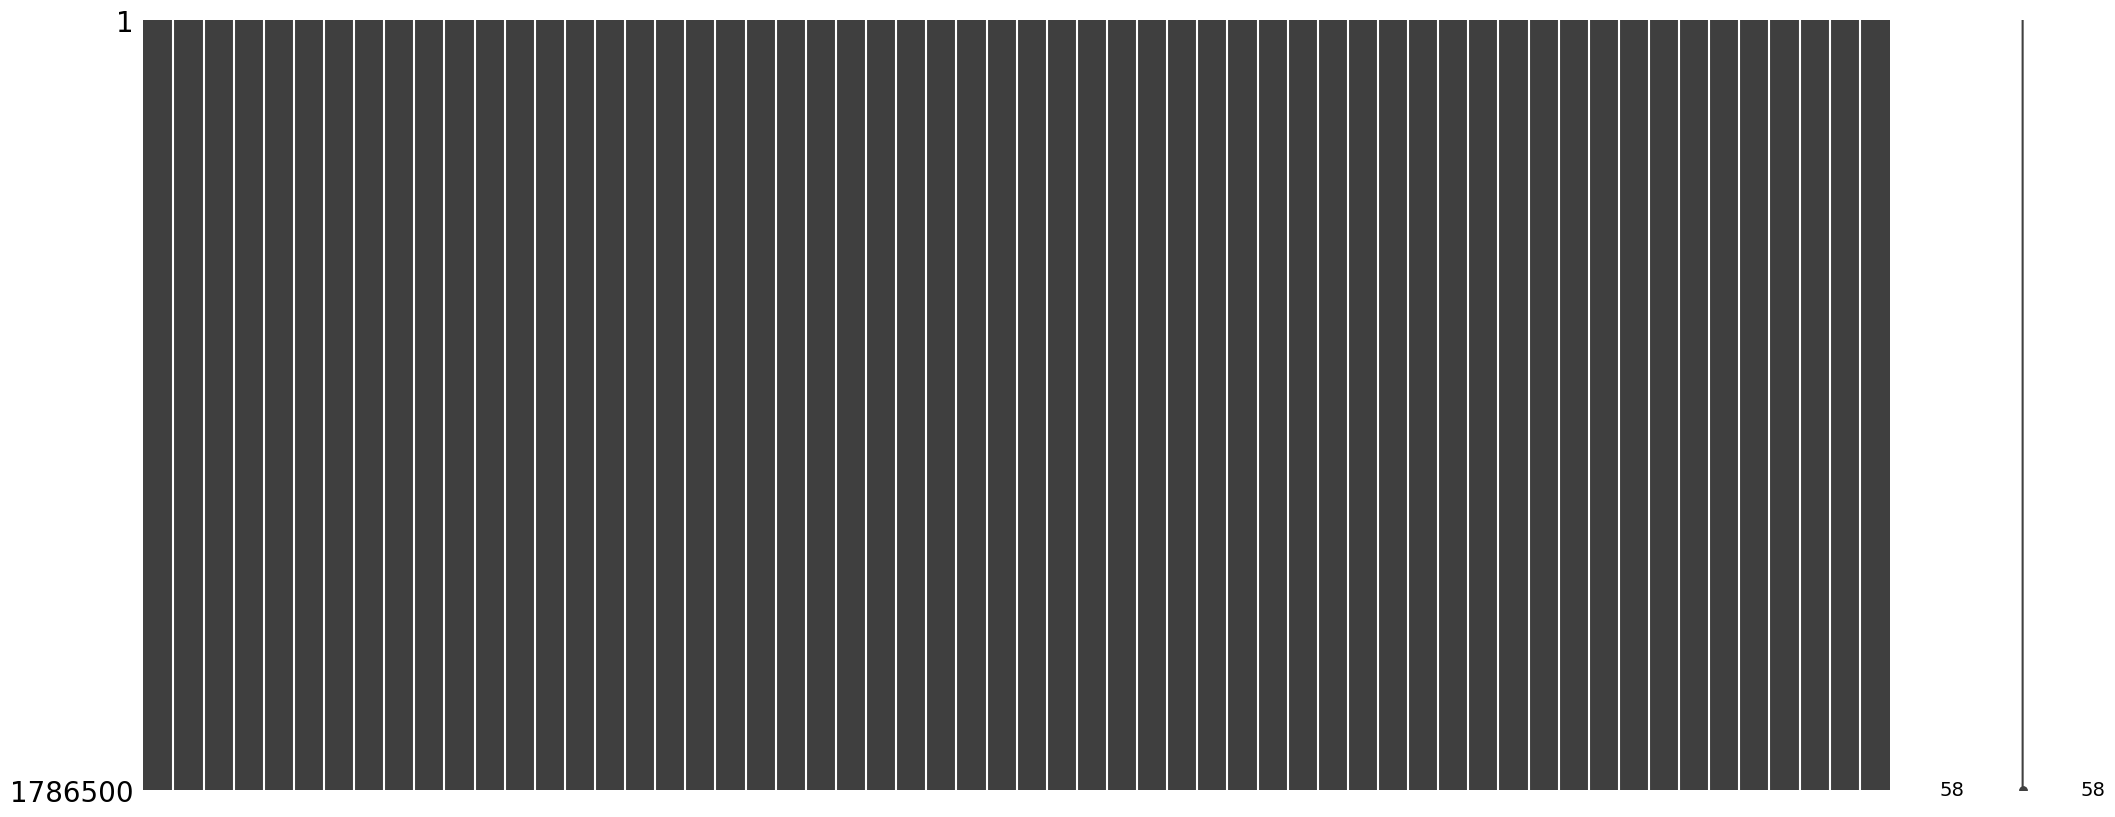

In [15]:
import missingno as msgo
msgo.matrix(teams)

In [16]:
teams.to_pickle('/home/arch-db/Documents/github/bint-capstone/data-sources/playoff_teams.pkl')